In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_loader
import pymc as pm
import arviz as az

In [42]:
df = data_loader.load_data()
dates = df.reset_index()['Date'].unique()
months = pd.DataFrame(np.arange(0, dates.size), index=dates)
df = df[df.columns[::-1]]
df['Month'] = np.tile(np.arange(0, dates.size), 51)
df = df[df.columns[::-1]]
X_cols = df.columns[2:-1]
y_col = df.columns[-1]

df_std = df.copy()
for col in X_cols:
    df_std[col] = (df[col] - df[col].mean()) / df[col].std()

pre_2016_std = df_std.iloc[np.where(df_std.reset_index()['Date'] < '2016-02-01')[0]]



In [43]:
X_cols

Index(['avg_prop_tax', 'proportion_American Indian/Aleut/Eskimo',
       'proportion_Asian only', 'proportion_Black', 'proportion_White',
       'total_population'],
      dtype='object')

In [17]:
state_list = df_std.reset_index()['statefip'].unique()
state_code = {state: i for i, state in enumerate(state_list)}

states = pre_2016_std.reset_index()['statefip'].apply(lambda x: state_code[x]).values

coords = {'state': state_list}


In [44]:
with pm.Model(coords=coords) as hierarchical_model:
    # Save data of the state indices
    state_idx = pm.MutableData('$s$', states, dims='obs_id')
    
    # Save the data for the independent variables
    time_data = pm.MutableData('$t$', pre_2016_std['Month'], dims='obs_id')
    tax_data = pm.MutableData('tax', pre_2016_std[X_cols[0]], dims='obs_id')
    population_data = pm.MutableData('population', pre_2016_std[X_cols[5]], dims='obs_id')
    native_data = pm.MutableData('native', pre_2016_std[X_cols[1]], dims='obs_id')
    asian_data = pm.MutableData('asian', pre_2016_std[X_cols[2]], dims='obs_id')
    black_data = pm.MutableData('black', pre_2016_std[X_cols[3]], dims='obs_id')
    white_data = pm.MutableData('white', pre_2016_std[X_cols[4]], dims='obs_id')

    # Hyperpriors for state-level intercepts and slopes
    mu = pm.Normal("mu", mu=200000, sigma=100000)
    sigma_mu = pm.Exponential("sigma_mu", 1 / 50000)
    eta = pm.Normal("eta", mu=1000, sigma=1000)
    sigma_eta = pm.Exponential("sigma_eta", 1 / 5000)

    # State-level intercepts and slopes
    beta_0 = pm.Normal("beta_0", mu=mu, sigma=sigma_mu, dims="state")
    beta_t = pm.Normal("beta_t", mu=eta, sigma=sigma_eta, dims="state")

    # Coefficients for predictors
    beta_tax = pm.Normal("beta_tax", mu=0, sigma=20)
    beta_pop = pm.Normal("beta_pop", mu=0, sigma=1)
    beta_native = pm.Normal("beta_native", mu=0, sigma=10000)
    beta_asian = pm.Normal("beta_asian", mu=0, sigma=10000)
    beta_black = pm.Normal("beta_black", mu=0, sigma=10000)
    beta_white = pm.Normal("beta_white", mu=0, sigma=10000)

    # Observation noise
    sigma = pm.HalfCauchy("sigma", beta=1000)

    # Expected value of the outcome
    P = (
        beta_0[state_idx]
        + beta_t[state_idx] * time_data
        + beta_tax * tax_data
        + beta_pop * population_data
        + beta_native * native_data
        + beta_asian * asian_data
        + beta_black * black_data
        + beta_white * white_data
    )

    # Likelihood (observed data)
    y_obs = pm.Normal("y_obs", mu=P, sigma=sigma, observed=pre_2016_std[y_col])

Sampling: [beta_0, beta_asian, beta_black, beta_native, beta_pop, beta_t, beta_tax, beta_white, eta, mu, sigma, sigma_eta, sigma_mu, y_obs]


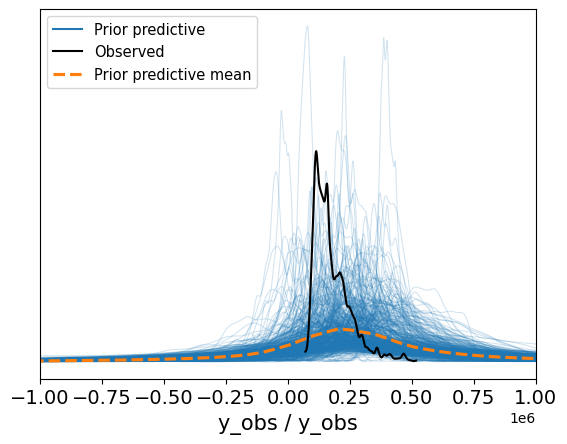

In [47]:
# Sample from the prior distribution
with hierarchical_model:
    prior = pm.sample_prior_predictive()

# prior

# Plot the prior predictive samples
az.plot_ppc(prior,  group='prior')#, var_names=["beta_0", "beta_t", "beta_tax", "beta_pop", "beta_native", "beta_asian", "beta_black", "beta_white"],
plt.xlim(-1e6, 1e6)
plt.savefig("prior_predictive_samples.png", dpi=300)
plt.show()

In [48]:
# To sample from the posterior distribution
with hierarchical_model:
    hierarchical_trace = pm.sample(1000, tune=1000, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma_mu, eta, sigma_eta, beta_0, beta_t, beta_tax, beta_pop, beta_native, beta_asian, beta_black, beta_white, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1199 seconds.
/opt/homebrew/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase

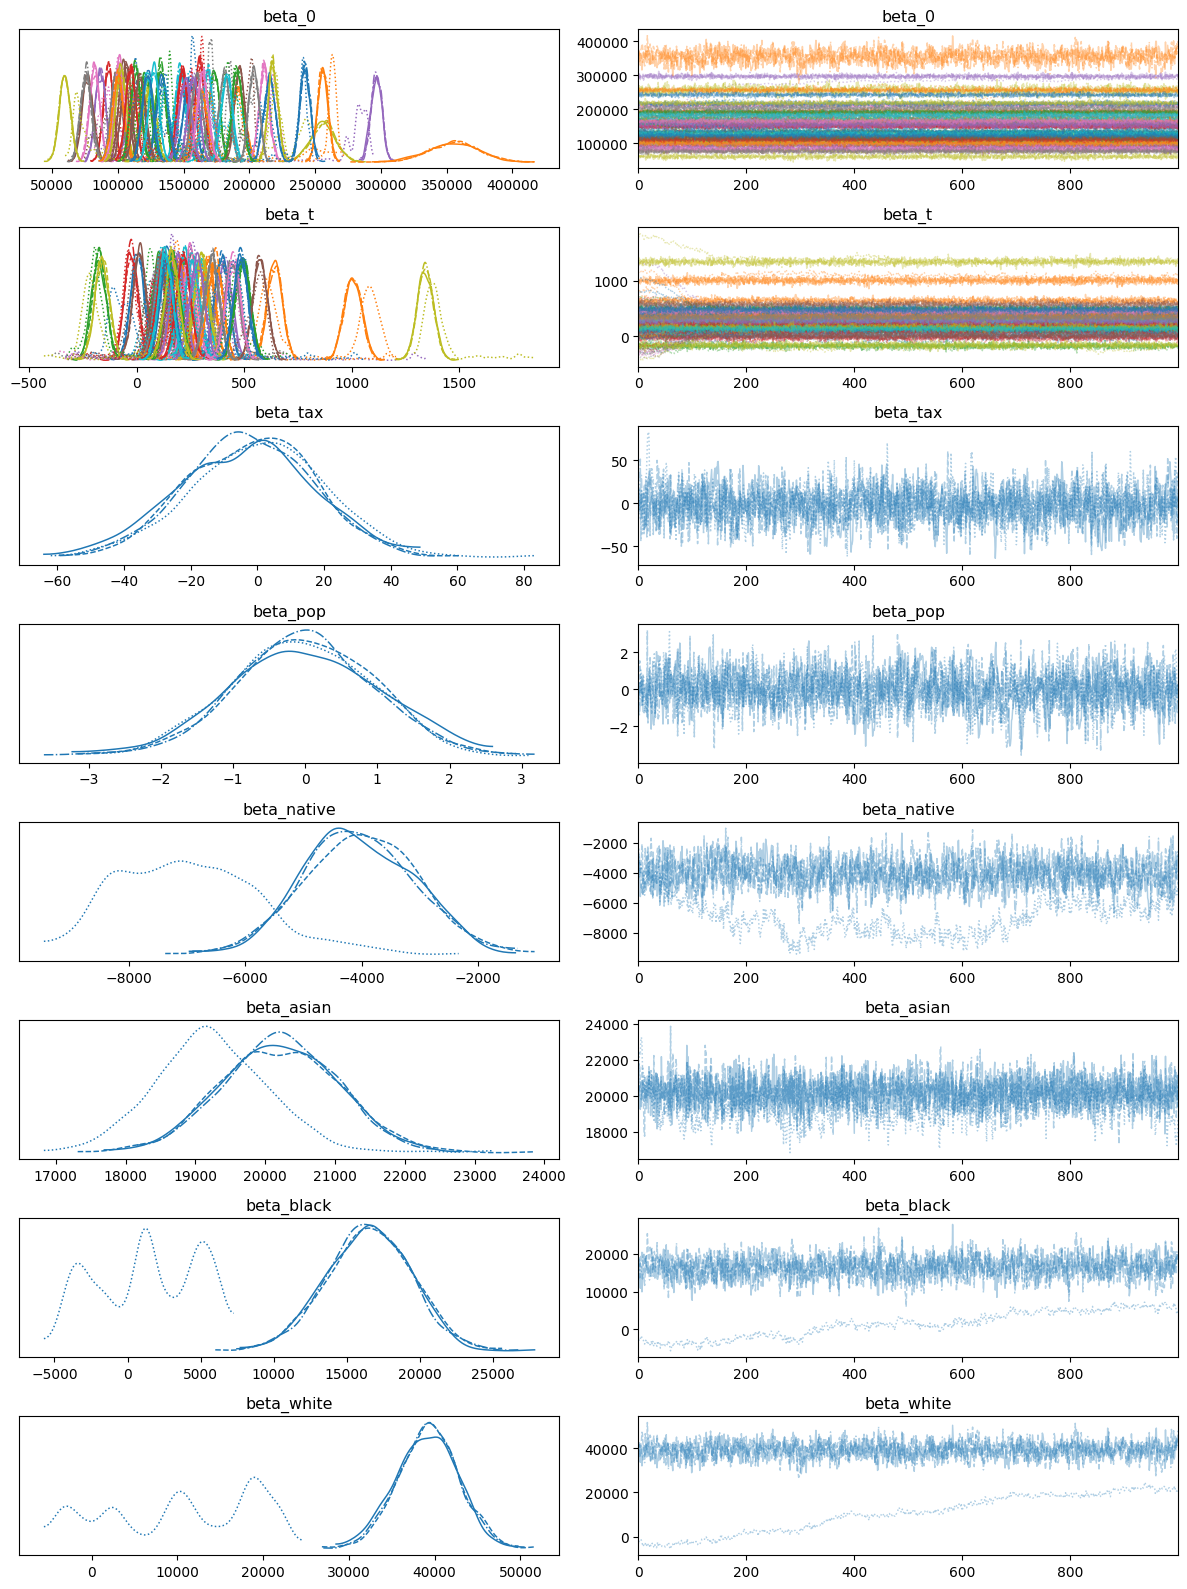

In [50]:
with hierarchical_model:
    az.plot_trace(hierarchical_trace, var_names=["beta_0", "beta_t", "beta_tax", "beta_pop", "beta_native", "beta_asian", "beta_black", "beta_white"])
    plt.tight_layout()
    plt.show()

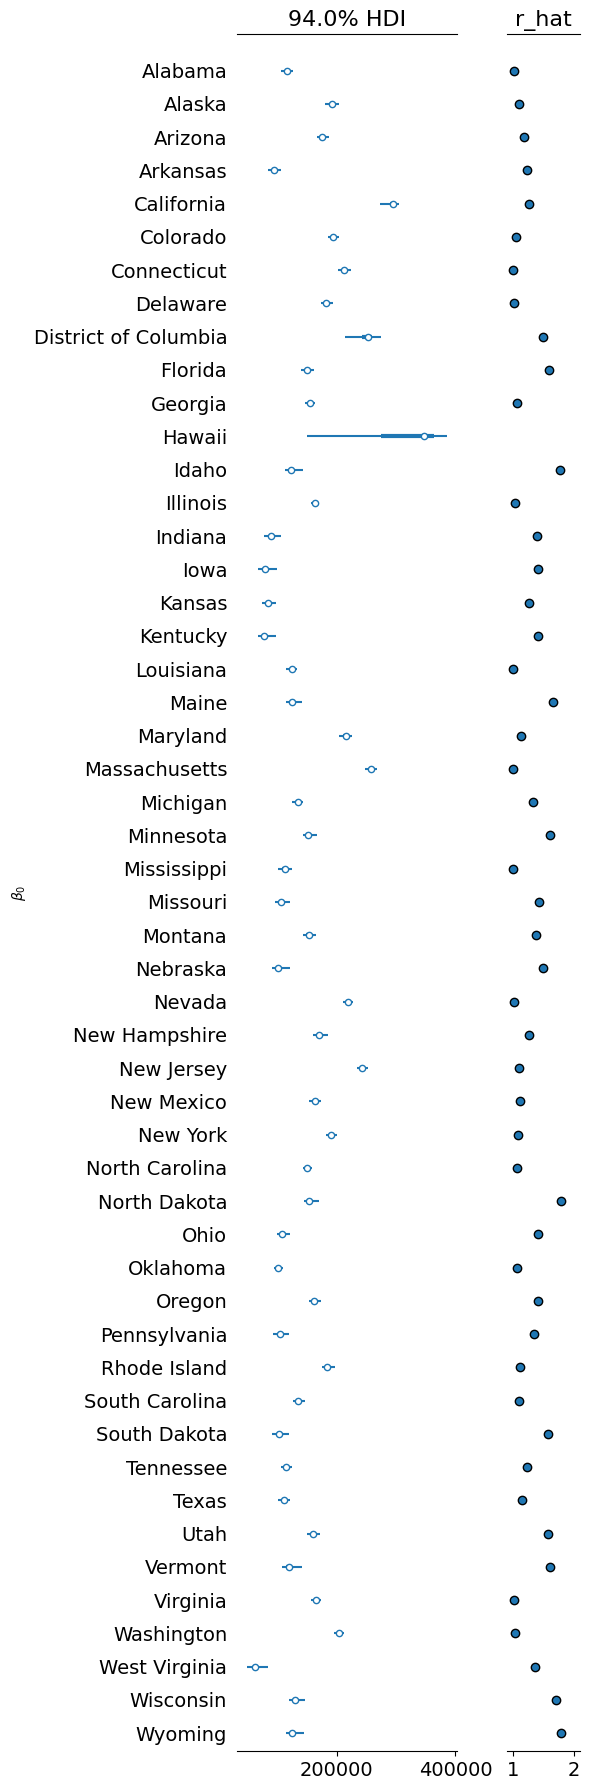

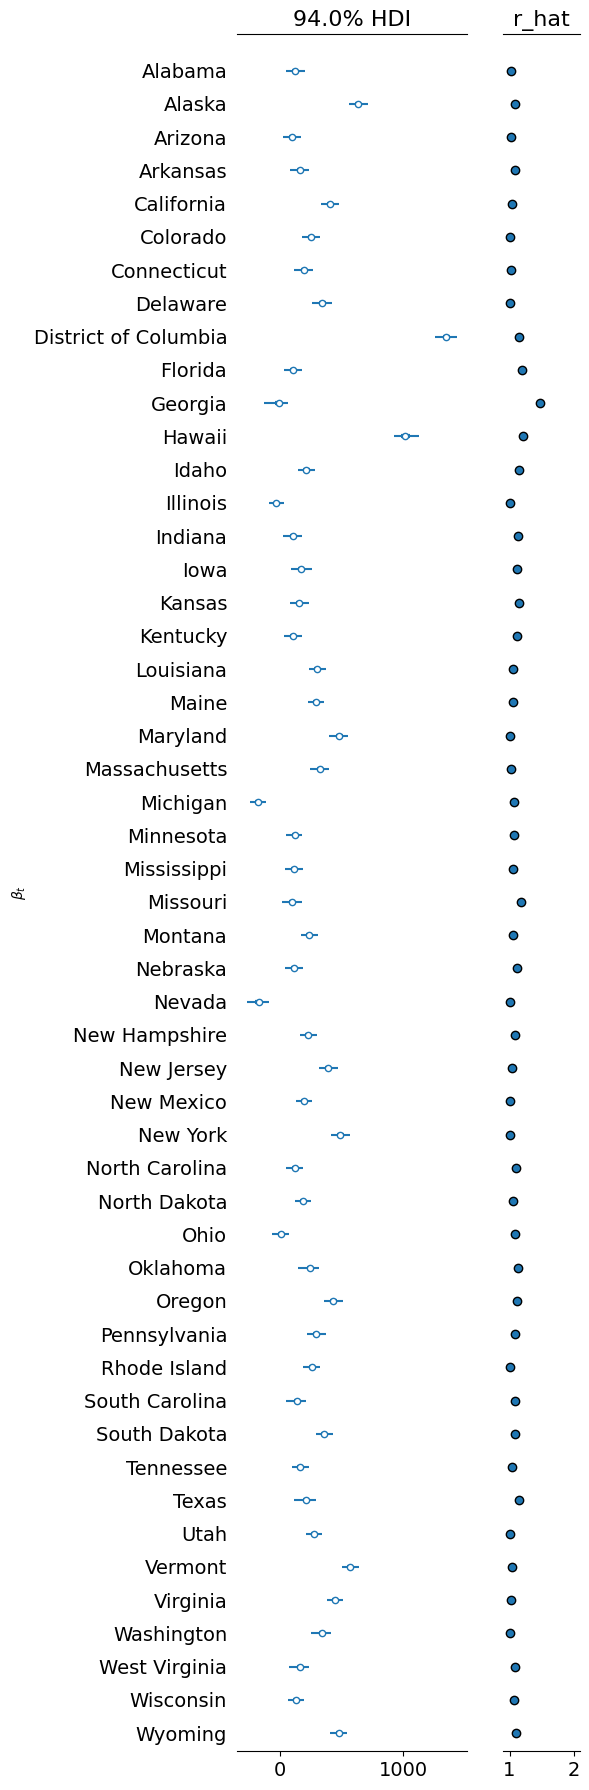

In [51]:
# Forest plot for beta_0
ax = pm.plot_forest(
    hierarchical_trace,
    var_names=["beta_0"],
    figsize=(6, 18),
    combined=True,
    r_hat=True,
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel(r"$\beta_0$")
plt.tight_layout()
plt.show()

# Forest plot for beta_t
ax = pm.plot_forest(
    hierarchical_trace,
    var_names=["beta_t"],
    figsize=(6, 18),
    combined=True,
    r_hat=True,
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel(r"$\beta_t$")
plt.tight_layout()
plt.show()